In [1]:
#begin with initial analysis, and remove stop words?
import time
import numpy as np
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import sklearn

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **font)

In [3]:
import os
train_r = pickle.load(open("train_r.pkl", "rb"))
train_b = pickle.load(open("train_b.pkl", "rb"))
valid_r = pickle.load(open("test_r.pkl", "rb"))
valid_b = pickle.load(open("test_b.pkl", "rb"))

In [4]:
#concatenate everythin appropriately to have the final datasets
one_label = np.ones(len(train_r))
zeros_label = np.zeros(len(train_b))
one_test = np.ones(len(valid_r))
zero_test = np.zeros(len(valid_b))

trainX = np.concatenate((train_r, train_b))
trainY = np.concatenate((one_label, zeros_label))
validX = np.concatenate((valid_r, valid_b))
validY  = np.concatenate((one_test, zero_test))

In [5]:
#gerenate feature vectors 
total_words = {}
for line in trainX:
    words = line.split(" ")
    for word in words:
        if word == "":
            continue
        try:
            total_words[word]
        except:
            total_words[word] = True

print(len(total_words.keys()))
#dont add words in valid and test sets

4818


In [6]:
#create training feats

#print(len(validX))
unique_keys = list(total_words.keys())
unique_keys.sort()
#print(unique_keys[:10])
#account for a bias
train_feats = np.zeros((len(trainX), len(total_words.keys()) ))
for i, line in enumerate(trainX):
    words = line.split(" ")
    #print(words)
    for word in words:
        if word =="":
            continue
        #print(unique_keys.index(word))
        ind = unique_keys.index(word)  
        #plus one is so that the very first is the bias (here a bias of zero)
        train_feats[i][ind] = 1


#create testing features
valid_feats = np.zeros((len(validX), len(total_words.keys())))
for i , line in enumerate(validX):
    words = line.split(" ")
    #print(len(words), end = " ")
    #if i ==0:
        #print(words)
    #print(words)
    for word in words:
        if word =="":
            continue
        #account for value error:
        try:
            ind = unique_keys.index(word) 
            #print(ind)
            valid_feats[i][ind] = 1
        except:
            continue       
#inds = np.where(valid_feats ==1)[1]
#print("\n", inds[:34])

In [7]:
from sklearn.ensemble import RandomForestClassifier
#ensemble method
rfc = RandomForestClassifier(random_state = 0, max_depth = 100, n_estimators = 100, n_jobs = -1, class_weight="balanced")

In [8]:
rfc.fit(train_feats, trainY)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [9]:
#confirm with cross val score
score = cross_val_score(rfc, train_feats, trainY, n_jobs= -1, cv = 5, scoring="f1", verbose = 5)
print(np.mean(score) ,np.std(score))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.8431703204047217, total=  11.8s
[CV]  ................................................................
[CV] ....................... , score=0.8369747899159664, total=  12.5s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.0s remaining:   19.4s


[CV] ....................... , score=0.8803986710963455, total=  12.9s
[CV] ....................... , score=0.8415841584158416, total=  12.9s
[CV] ....................... , score=0.8547297297297298, total=   4.0s
0.851371533912521 0.015647178864262576


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished


In [10]:
preds = rfc.predict(valid_feats)
a_score = metrics.accuracy_score(validY, preds)
score  = metrics.average_precision_score(validY, preds)
print(a_score, score)

0.8187372708757638 0.7935482391714201


In [2]:
import matplotlib.pyplot as plt

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


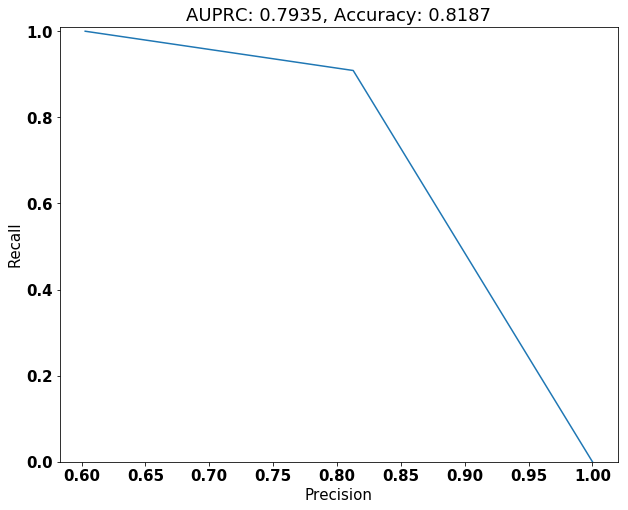

In [11]:
# plot graph
plt.figure(figsize=(10,8))
precision, recall, thresh = metrics.precision_recall_curve(validY, preds)
plt.plot(precision, recall)
plt.title("AUPRC: {0:.04}, Accuracy: {1:.04}".format(score, a_score))
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.ylim([0,1.01])
plt.show()

In [12]:
score = cross_val_score(rfc, train_feats, trainY, n_jobs= -1, cv = 5, scoring="accuracy")
print(np.mean(score) ,np.std(score))

0.8058570923021964 0.020196921798536882


In [13]:
score = cross_val_score(rfc, train_feats, trainY, n_jobs= -1, cv = 5, scoring="average_precision")
print(np.mean(score) ,np.std(score))

0.9301056885085751 0.004251564644914123


accuracy is not good for imbalanced sets, and the other two compensate for that. explain diff between f1 and average precision scoring metrics

In [14]:
# do feature score evaluation
importances = rfc.feature_importances_
import_keys = np.argsort(importances)[::-1]
print(import_keys[:10])
import_keys = np.flip(import_keys, axis = 0)
importances = np.sort(importances)
importances = np.flip(importances, axis = 0)

[4285 1333 4429 2016 4413 4525   77 2265 2356  242]


[0 1 2 3 4 5 6 7 8 9] [0.03823946 0.03382351 0.02028465 0.01918675 0.01502512 0.01273438
 0.01204756 0.00990484 0.00934945 0.00817969]
[1837 2548 2550 2553 3510 3497 2558  812 4205 4206]
['google' 'locals' 'locked' 'lodged' 'related' 'regulation' 'londons'
 'christopher' 'table' 'tabloid']


/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


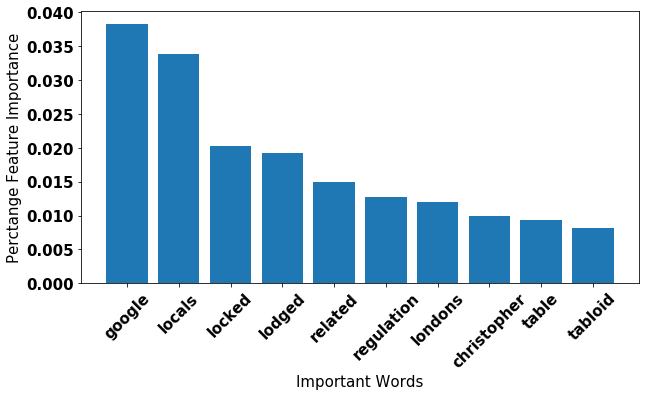

In [15]:
x = np.arange(10)
print(x, importances[:10])
print(import_keys[:10])
#
unique_keys = np.asarray(unique_keys)
print(unique_keys[import_keys[:10]])

#unique_keys = np.flip(unique_keys)
#print(unique_keys[import_keys[:10]])
#plt.bar(unique_keys[import_keys[:10]], importances[:10])
#plt.xticks(rotation = 45)
#plt.xticks_labels()
#plt.x_range = FactorRange(factors=unique_keys[import_keys[:10]])
#plt.show()
fig  = plt.figure(figsize=(10,5))
ax = fig.add_subplot("111")
#ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, importances[:10])
ax.set_xticks(x)
plt.ylabel("Perctange Feature Importance")
plt.xlabel("Important Words")
ax.set_xticklabels(unique_keys[import_keys[:10]], rotation = 45)
plt.show()

In [16]:
# use pca data, to get rid of data of wrds that are barely used
#reduce features by half
from sklearn.decomposition import PCA
pca = PCA(n_components = 1000)
pca.fit(train_feats)
trimmed_train = pca.transform(train_feats)
trimmed_valid = pca.transform(valid_feats)
print(trimmed_train.shape)

(2287, 1000)


In [17]:
score = cross_val_score(rfc, trimmed_train, trainY, n_jobs= -1, cv = 5, scoring="accuracy")
print(np.mean(score) ,np.std(score))

0.7992924989702812 0.019434969999769996


In [18]:
score = cross_val_score(rfc, train_feats, trainY, n_jobs= -1, cv = 5, scoring="average_precision")
print(np.mean(score) ,np.std(score))

0.9301056885085751 0.004251564644914123


In [19]:
# if features have been reduced, it doesn't make sense that you need the same tree depth, reduce depth as well
# and then rerun the tests
rfc2 = RandomForestClassifier(random_state = 0, max_depth = 15, n_estimators = 500, n_jobs = -1, verbose=True)

In [20]:
score = cross_val_score(rfc2, trimmed_train, trainY, n_jobs= -1, cv = 5, scoring="accuracy")
print(score)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.9s f

[0.82969432 0.8209607  0.84497817 0.82713348 0.81578947]


In [21]:
print(np.mean(score) ,np.std(score))
rfc2.fit(trimmed_train, trainY)
preds = rfc2.predict(trimmed_valid)
print("score", metrics.accuracy_score(validY, preds))
#generalizes poorly 

0.8277112281338781 0.009900620967684013


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


score 0.745417515274949
